In [4]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from scipy.linalg import expm

In [5]:
Z = np.array([[1, 0], 
              [0, -1]])

Y = np.array([[0, -1j],
              [1j, 0]])

X = np.array([[0, 1],
              [1, 0]])

I = np.array([[1, 0],
              [0 ,1]])

Hadamard = (1/np.sqrt(2))*np.array([[1, 1],
                                    [1, -1]])

zero_state = np.array([1, 0])
plus_state = Hadamard @ zero_state

## Single qubit

In [6]:
hamiltonian = Z

w, v = np.linalg.eigh(hamiltonian)
ground_state = v[:, 0]
gs_energy = w[0]

print("Ground state energy:", gs_energy)
print("Ground state:", ground_state)

Ground state energy: -1.0
Ground state: [0. 1.]


In [7]:
def weak_measurement(state, H, eps=0.01):
    new_state = np.kron(plus_state, state)
    new_state = expm(-1j * eps * np.kron(Y, H)) @ new_state
    probs = np.abs(new_state)**2
    prob = np.sum(probs[:len(probs)//2])
    if np.random.rand() < prob:
        return new_state[:len(probs)//2] / np.sqrt(prob), 0
    return new_state[len(probs)//2:] / np.sqrt(1 - prob), 1

In [8]:
def random_state(n):
    vector_size = 2 ** n
    real_part = np.random.randn(vector_size)
    imag_part = np.random.randn(vector_size)
    complex_vector = real_part + 1j * imag_part
    return complex_vector / np.linalg.norm(complex_vector)

In [9]:
class GaussianFeedback:
    def __init__(self, eps, Eth):
        self.k0 = 0
        self.k1 = 0
        self.eps = eps
        self.Eth = Eth

    def _x_max(self):
        if self.k0 == 0 and self.k1 == 0:
            return 1
        return np.arcsin((self.k1 - self.k0)/(self.k1 + self.k0)) / 2

    def cond(self):
        val = self._x_max()
        if val > self.eps * self.Eth:
            self.k0 = 0
            self.k1 = 0
            return val, True
        return val, False        

    def update(self, m):
        self.k0 += (1 - m)
        self.k1 += m

In [10]:
def fidelity(s1, s2):
    return np.abs(s1.conj() @ s2)**2

In [11]:
state = random_state(1)
eps = 0.2
Eth = 0
feedback = GaussianFeedback(eps, Eth)
fidelities = []
x_maxes = []

for i in range(100):
    state, m = weak_measurement(state, hamiltonian, eps)
    feedback.update(m)
    x_max, cond = feedback.cond()
    x_maxes.append(x_max)
    if cond:
        state = X @ state
    fidelities.append(fidelity(state, ground_state))

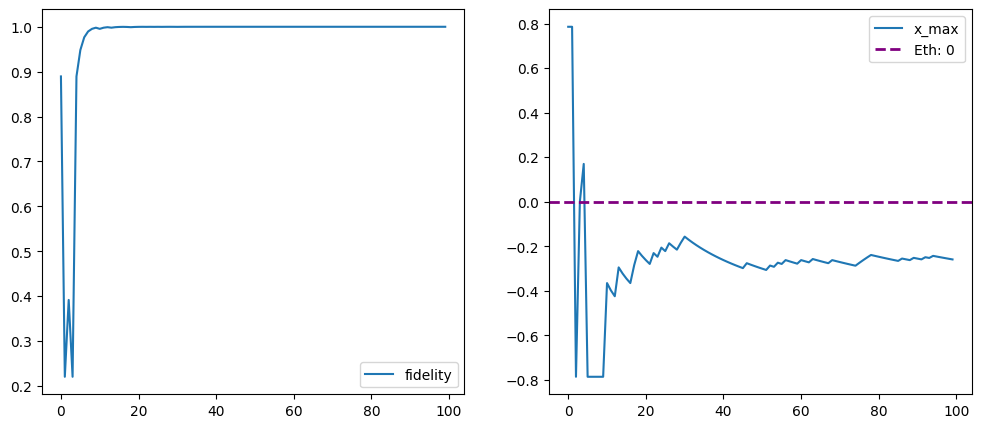

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
ax1.plot(fidelities, label='fidelity')
ax2.plot(x_maxes, label='x_max')
ax2.axhline(y=Eth, color="purple", ls="--", lw=2, label=f"Eth: {Eth}")
ax1.legend()
ax2.legend()

In [19]:
def get_hamiltonian(hamiltonian_terms, coefficients):
    n = 2 ** len(hamiltonian_terms[0])
    hamiltonian = np.zeros((n, n), dtype=np.complex128)
    for i in range(len(hamiltonian_terms)):
        term = hamiltonian_terms[i]
        coeff = coefficients[i]
        operator = 1
        for j in range(len(term)):
            if term[j] == 'X':
                operator = np.kron(operator, np.array([[0, 1], [1, 0]]))
            elif term[j] == 'Y':
                operator = np.kron(operator, np.array([[0, -1j], [1j, 0]]))
            elif term[j] == 'Z':
                operator = np.kron(operator, np.array([[1, 0], [0, -1]]))
            elif term[j] == 'I':
                operator = np.kron(operator, np.array([[1, 0], [0, 1]]))
        hamiltonian += coeff * operator
    return hamiltonian

In [20]:
def random_param_circuit(num_qubits):
    """
    Returns the matrix of a randomly parameterized quantum circuit with Rx, Ry, Rz gates applied
    on every qubit with random parameters.

    Args:
        num_qubits (int): The number of qubits in the circuit.

    Returns:
        ndarray: The matrix of the quantum circuit.
    """
    
    # Generate random parameters for Rx, Ry, Rz gates
    thetas = np.random.uniform(0, 2 * np.pi, size=(num_qubits, 3))
    
    # Generate matrix for each X, Y, Z gate
    Z = np.array([[1, 0], 
                  [0, -1]])

    Y = np.array([[0, -1j],
                  [1j, 0]])

    X = np.array([[0, 1],
                  [1, 0]])

    # Compute matrix for the quantum circuit
    operators = []
    for i in range(num_qubits):
        Rx = expm(-1j * thetas[i,0] * X / 2)
        Ry = expm(-1j * thetas[i,1] * Y / 2)
        Rz = expm(-1j * thetas[i,2] * Z / 2)
        operators.append(Rz @ Ry @ Rx)
    
    circuit_matrix = reduce(np.kron, operators)
    return circuit_matrix

## Heisenberg model

In [21]:
L = 3

ops = []
coeffs = []
id_op = ['I']*L

for op in ['X','Y','Z']:
    for i in range(L-1):
        temp_op = id_op.copy()
        temp_op[i] = op
        temp_op[i+1] = op
        ops.append(''.join(temp_op))
        coeffs.append(1.0)

hamiltonian = get_hamiltonian(ops, coeffs)
w, v = np.linalg.eigh(hamiltonian)
ground_state = v[:, 0]
gs_energy = w[0]

print("Ground state energy:", gs_energy)
print("Ground state:", ground_state)

Ground state energy: -4.0
Ground state: [-0.        +0.j  0.40824829+0.j -0.81649658+0.j  0.        +0.j
  0.40824829+0.j -0.        +0.j -0.        +0.j -0.        +0.j]


In [22]:
random_circuit = random_param_circuit(L)

In [30]:
state = random_state(L)
eps = 0.1
Eth = -0.4
feedback = GaussianFeedback(eps, Eth)

fidelities = []
x_maxes = []

for i in range(200):
    state, m = weak_measurement(state, hamiltonian, eps)
    feedback.update(m)
    x_max, cond = feedback.cond()
    x_maxes.append(x_max)
    if cond:
        state = random_circuit @ state
    fidelities.append(fidelity(state, ground_state))

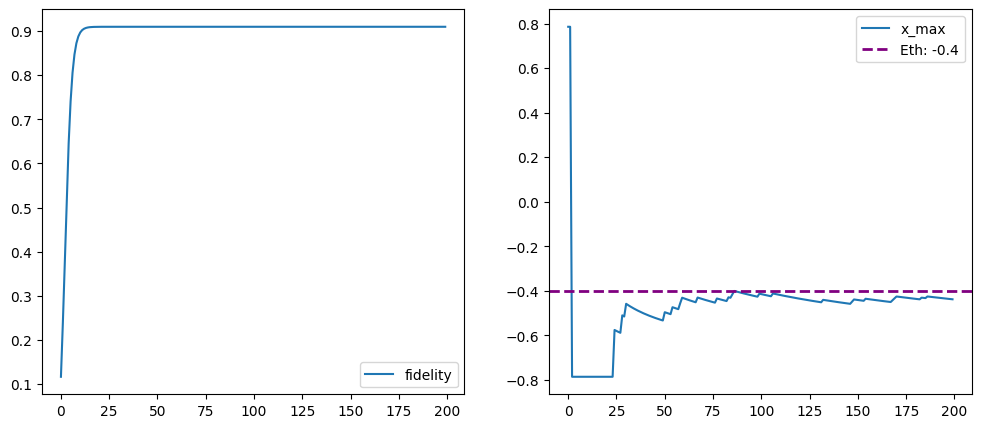

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
ax1.plot(fidelities, label='fidelity')
ax2.plot(x_maxes, label='x_max')
ax2.axhline(y=Eth, color="purple", ls="--", lw=2, label=f"Eth: {Eth}")
ax1.legend()
ax2.legend()